In [12]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
class CustomMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False) -> None:
        # Initialize the custom dataset by loading data from the given CSV file.
        # csv_file: The path to the CSV file containing the data.
        # transform: Optional transformations to apply to each image (e.g., ToTensor, Normalize).
        # is_test: A boolean flag indicating if it's the test dataset (no labels in test set).

        self.dataframe = pd.read_csv(csv_file) 
        self.transform = transform  # Store the transformation function if provided.
        self.is_test = is_test  # Set whether the dataset is for testing (no labels available).

    def __len__(self):
        # Return the length of the dataset, i.e., the number of rows in the dataframe.
        return len(self.dataframe) 
    
    def __getitem__(self, index):
        # Retrieve a specific sample (row) from the dataframe by index.
        item = self.dataframe.iloc[index]  # Fetch the row corresponding to the given index.

        # Handle test dataset (no labels present) differently from training/validation dataset:
        if self.is_test:
            # If it's the test set, we only have image data (no labels).
            # The entire row is reshaped to 28x28 to represent an image.
            image = item.values.reshape(28, 28).astype(np.uint8)
            label = None  # No label for the test dataset.
        else:
            # For training/validation sets, the first column is the label (digit).
            # The remaining columns contain pixel values for the image.
            image = item[1:].values.reshape(28, 28).astype(np.uint8)
            label = item.iloc[0]  # The label (digit) is the first element.

        # Convert the NumPy image array to a PIL Image format, which is common for applying transformations.
        image = transforms.ToPILImage()(image)

        # Apply any specified image transformations (like normalization, augmentations).
        if self.transform is not None:
            image = self.transform(image)

        # Return image and label for training/validation sets, but only image for test set (since no labels).
        if self.is_test:
            return image  # Only return the image for the test set (no label).
        else:
            return image, label  # Return the image and its corresponding label for training/validation.


In [15]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [16]:
train_dataset = CustomMNISTDataset(csv_file = 'train.csv', transform= transform, is_test=False)
test_dataset = CustomMNISTDataset(csv_file = 'test.csv', transform= transform, is_test=True)

In [17]:
print(f'train size: ' + str(len(train_dataset))+ ', test size: ' + str(len(test_dataset)))

train size: 42000, test size: 28000


In [18]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

# Visulise the images (code from ChatGPT)

Input size: torch.Size([64, 1, 28, 28])


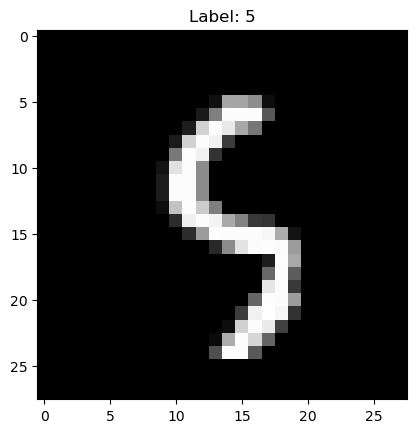

Input size: torch.Size([64, 1, 28, 28])


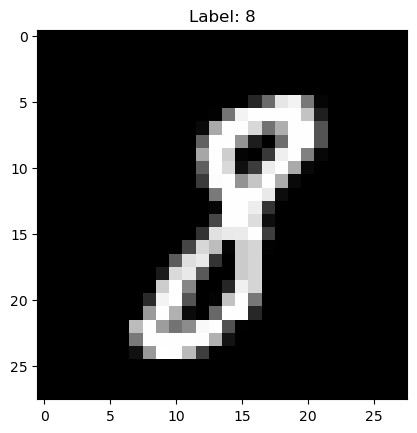

In [19]:
num_images_to_show = 2

for i, (example_data, example_labels) in enumerate(train_loader):
    if i >= num_images_to_show:
        break  # Stop after displaying the desired number of images

    example_image = example_data[0]  # Take the first image in the batch
    print(f'Input size: {example_data.size()}')  

    # Convert the image to numpy and squeeze to remove the extra channel
    example_image_numpy = example_image.numpy().squeeze()

    plt.imshow(example_image_numpy, cmap='gray')  # Display the image in grayscale
    plt.title(f'Label: {example_labels[0].item()}')  
    plt.show()


In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First convolutional layer: 1 input channel (grayscale image), 32 output channels (filters), 
        # 3x3 kernel, stride of 1, and padding of 1 to preserve image size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # ReLU activation function to introduce non-linearity
        self.relu = nn.ReLU()
        
        # MaxPooling layer: reduces spatial dimensions by a factor of 2 (from 28x28 to 14x14)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer: takes 32 input channels and outputs 64 feature maps
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Third convolutional layer: takes 64 input channels and outputs 128 feature maps
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Fully connected (dense) layer: needs reshaped input size (flattened output from conv layers)
        # The input size is derived from 128 feature maps of size 7x7 after pooling
        self.fc1 = nn.Linear(128 * 7 * 7, 128)  # Adjusting input size to match the flattened dimensions
        
        # Dropout layer to prevent overfitting by randomly setting some neuron activations to zero
        self.dropout = nn.Dropout(0.5)

        # Second fully connected layer: 128 input neurons, 20 output neurons (hidden layer)
        self.fc2 = nn.Linear(128, 20)
        
        # Final fully connected layer: maps 20 features to 10 output classes (MNIST has 10 classes)
        self.fc3 = nn.Linear(20, 10)  

    def forward(self, x):
        # Forward pass through first convolution, activation, and pooling
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Forward pass through second convolution, activation
        x = self.conv2(x)
        x = self.relu(x)

        # Forward pass through third convolution and pooling
        x = self.conv3(x)
        x = self.pool(x)

        # Flatten the output from the conv layers for the fully connected layers
        # The size after pooling is 7x7 for each of the 128 feature maps
        x_size = x.size(1) * x.size(2) * x.size(3)
        x = x.view(-1, x_size)

        # Forward pass through fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x  # Final output with class scores (logits)


        

In [21]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr = 0.001, momentum=0.09)

In [22]:
num_epochs = 100  
running_loss = 0.0  


for epoch in range(num_epochs):

    # Loop over batches of data in the train_loader
    for i, data in enumerate(train_loader, 0):  # Enumerate over the DataLoader to get batches (index and data)
        inputs, labels = data  # Extract inputs (images) and labels (true digit classes) from the batch
        
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset the gradients from the previous iteration to prevent accumulation
        optimiser.zero_grad()

        # Perform forward pass: pass inputs through the model to get the predictions (outputs)
        outputs = model(inputs.float())  # Ensure inputs are in the correct type (float)

        # Calculate the loss between the model's predictions (outputs) and the actual labels
        loss = criterion(outputs, labels)

        # Backpropagation: compute gradients of the loss w.r.t. model parameters
        loss.backward()

        # Perform a step of optimization (update model parameters)
        optimiser.step()

        # Accumulate loss for reporting later
        running_loss += loss.item()

      
        if i % 100 == 99:  # Check if processed 100 batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}')  # Average loss over the last 100 batches
            running_loss = 0.0  


print('Training finished')


[1, 100] loss: 2.307
[1, 200] loss: 2.308
[1, 300] loss: 2.304
[1, 400] loss: 2.307
[1, 500] loss: 2.301
[1, 600] loss: 2.300
[2, 100] loss: 3.609
[2, 200] loss: 2.298
[2, 300] loss: 2.297
[2, 400] loss: 2.296
[2, 500] loss: 2.294
[2, 600] loss: 2.293
[3, 100] loss: 3.596
[3, 200] loss: 2.290
[3, 300] loss: 2.287
[3, 400] loss: 2.286
[3, 500] loss: 2.282
[3, 600] loss: 2.281
[4, 100] loss: 3.578
[4, 200] loss: 2.276
[4, 300] loss: 2.271
[4, 400] loss: 2.268
[4, 500] loss: 2.265
[4, 600] loss: 2.261
[5, 100] loss: 3.541
[5, 200] loss: 2.249
[5, 300] loss: 2.241
[5, 400] loss: 2.236
[5, 500] loss: 2.229
[5, 600] loss: 2.218
[6, 100] loss: 3.458
[6, 200] loss: 2.185
[6, 300] loss: 2.170
[6, 400] loss: 2.146
[6, 500] loss: 2.125
[6, 600] loss: 2.088
[7, 100] loss: 3.201
[7, 200] loss: 1.973
[7, 300] loss: 1.910
[7, 400] loss: 1.842
[7, 500] loss: 1.765
[7, 600] loss: 1.647
[8, 100] loss: 2.388
[8, 200] loss: 1.361
[8, 300] loss: 1.244
[8, 400] loss: 1.132
[8, 500] loss: 1.040
[8, 600] loss

In [23]:
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        outputs = model(data)

        _, predicted = torch.max(outputs.data,1)
        predictions.extend(predicted.cpu().tolist())

submission = pd.DataFrame({
    'ImageID': range(1, len(predictions)+1),
    'label' : predictions
})

submission.to_csv('predictions2204final.csv', index=False)